In [1]:
from typing import Iterator,Tuple
from functools import reduce
from operator import concat

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import wasserstein_distance, poisson, geom, bernoulli
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
import plotly.graph_objects as go

from tqdm import tqdm

cmap = get_cmap('tab10')(np.linspace(0,1,10))
sch.set_link_color_palette([rgb2hex(rgb[:3]) for rgb in cmap])


# Dependencies

This code was written in Python 3.7, and depends on some standard Python packages (`typing`, `operator`, and
`functools`) as well as additional but commonly-used packages for data science
(`numpy`, `scipy`, `scikit-learn`) and visualization (`matplotlib`, `plotly`), as
well as the `tqdm` package for progress bars when generating data/running long
code. The versions used are:

| Package | Version |
|---------|---------|
| `numpy`   | 1.20.1 |
| `scipy`   | 1.7.0 |
| `scikit-learn` | 1.0.1 |
| `matplotlib` | 3.5.1 |
| `plotly` | 4.14.3 |
| `tqdm` | 4.61.0 |


# Basic functions

### The Cantor Embedding

The function `cantor` receives a sequence of symbols and an alphabet from which
the symbols are drawn, and returns the Cantor embedding of the sequence, as
defined in our paper:

$$
C(x_1\dots x_k) = \sum_{\ell=1}^k \frac{2J_{x_\ell}}{(2|\mathcal{A}|-1)^\ell}
$$

where $\mathcal{A}$ is the alphabet and $J_x$ (corresponding to the function
`encode` below) encodes each unique $x\in\mathcal{A}$
as an integer in $1,\dots,|\mathcal{A}|$.

In [2]:
def encode(
    b:str,              # A symbol
    alphabet:np.ndarray # Array of possible symbols
)->int:    
    """
    This computes J_b.
    """ 
    return np.where(alphabet==b)[0][0]

def cantor(
    bs:np.ndarray,      # A sequence of symbols
    alphabet:np.ndarray # Array of possible symbols
)->float:
    """
    This computes the Cantor embedding as a sum.
    """     
    A = len(alphabet)
    return sum([2*encode(b,alphabet)/(2*A-1)**(l+1) for l,b in enumerate(bs)])

### Time-series plots

The next code block implements Algorithm 1 from the paper, which parses a time
series and, for a given past length and future length, collects the set of
unique past words, Cantor embeddings of the future words, and the Wasserstein
matrix constructed from empirical Cantor distributions. We also include a method
which generates pairs of past Cantor embeddings with future Cantor embeddings,
for use in the 2D Cantor plots in Fig. 1 of the paper.

In [3]:
def PF_pairs(
    Xs:np.ndarray,  # Time series of categorical observations
    LP:int=2,       # Desired length of past words
    LF:int=2        # Desired length of future words
)->Iterator[tuple]:
    """
    Creates an iterator containing all observed pairs of (past word, future word).
    """
    return ((wind[0:LP],wind[LP:LP+LF]) for wind in sliding_window_view(Xs,LP+LF))
        
def CantorWasserstein(
        pairs:Iterator[tuple]  # Iterator of (past,future) pairs
)->Tuple[np.ndarray,list,np.ndarray]:
    """
    Returns an array containing all unique past words observed, a list
    containing, for each unique past, a list of all future words seen with that
    past, and a Wasserstein distance matrix in compressed form (that is,
    containing only the upper triangular part, since the full matrix is symmetric).
    """
    # This extracts the list of pasts and list of futures from the list of pairs
    ps,fs = zip(*pairs)     
    # Cantor embedding all futures
    f_cantors = np.array([cantor(b,alphabet) for b in tqdm(list(fs),desc='Cantor embedding futures')])
    # Collect unique pasts using np.unique, and pull all futures seen adjacent to each unique past
    unq_pasts = np.unique(np.array(list(ps)),axis=0)
    cantors = [f_cantors[np.where(np.all(past==ps,axis=1))] for past in tqdm(unq_pasts,desc='Building empirical dists')]
    # Compute compressed Wasserstein matrix
    pwass = np.array(list(reduce(concat,
        [
            [wasserstein_distance(cs_k,cs_l) for cs_l in cantors[k+1:]] 
            for k,cs_k in tqdm(list(enumerate(cantors)),desc='Evaluating condensed Wasserstein matrix')
        ]
    )))
    return unq_pasts,cantors,pwass

This code will be used to generate the 2D Cantor plots from Figure 1.

In [41]:
def cantor_pairs(
    pairs:Iterator[tuple]  # Iterator of (past,future) pairs
)->Iterator[tuple]:
    """
    Creates an iterator containing pairs of (past,future) cantor embeddings, for
    use in the 2D Cantor plots.
    """
    return ((cantor(reversed(p),alphabet),cantor(f,alphabet)) for p,f in tqdm(list(pairs),desc='Computing Cantor pairs'))

def scatter_cantor(
    Xs:np.ndarray,                  # Time series of categorical observations
    LP:int=2,                       # Desired length of past words
    LF:int=2,                       # Desired length of future words
    figsize:Tuple[int,int]=(5,5)    # Desired figure size
)->Tuple[plt.Figure,plt.Axes]:
    """
    Generates the 2D Cantor plot from a time series.
    """
    # Get alphabet of unique categories
    alphabet = np.unique(Xs)
    A = len(alphabet)
    
    # Compute pairs of Cantor embeddings, extract past & future lists from pairs
    xs,ys = zip(*cantor_pairs(PF_pairs(Xs,LP=LP,LF=LF)))

    # Construct the scatter plot
    fig,ax = plt.subplots(figsize=figsize)
    plt.scatter(x=xs,y=ys,s=1.0,linewidths=0,color='k')

    # Setup axes
    ax.tick_params('both',length=0,pad=10,which='minor')
    step = 1/(2*A-1)

    ax.set_xticks(np.arange(0,1+step,step))
    ax.set_xticks(np.arange(step/2,1,2*step),minor=True,)
    ax.set_yticks(np.arange(0,1+step,step))
    ax.set_yticks(np.arange(step/2,1,2*step),minor=True,)
    
    ax.set_yticklabels(['']*(2*A))
    ax.set_yticklabels(alphabet,minor=True,fontfamily='monospace')
    ax.set_xticklabels(['']*(2*A))
    ax.set_xticklabels(alphabet,minor=True,fontfamily='monospace')
    return fig,ax

Lastly, we include the code used for generating the clustered Cantor diagrams in
Fig. 2 of the paper.

In [25]:
def cluster_cantor(
    unq_pasts:np.ndarray,                   # Array of unique past words
    cantors:list,                           # List of empirical Cantor distributions
    wass:np.ndarray,                        # Compressed Wasserstein matrix
    color_threshold:float=0,                # Distance scale at which to color-code clusters
    figsize:Tuple[float,float]=(18,14),     # Figure size
    dendro_rect:list=[0.09,0.1,0.2,0.8],    # Dimensions of Y-axis dendrogram: left- and bottom- coordinates + width and height
    dist_norm:np.ufunc=np.sqrt,             # Scaling function for dendrogram distance axis
    matrix_rect:list=[0.325,0.1,0.6,0.8],   # Dimensions of main plot: left- and bottom- coordinates + width and height
)->Tuple[plt.Figure,dict]:
    """
    Generates the clustered Cantor diagram from the pre-processed data
    containing the unique pasts, empirical Cantor distributions, and the
    Wasserstein matrix. Returns the full figure and a dictionary with the
    dendrogram properties (which will be used to extract cluster colors in later
    plots).
    """

    # Getting the alphabet
    alphabet = np.unique(Xs)
    A = len(alphabet)
    unq_pasts = np.array([''.join(s) for s in unq_pasts])
    
    # Creating the figure
    fig = plt.figure(figsize=figsize)
    axdendro = fig.add_axes(dendro_rect)

    # Clustering the Wasserstein matrix and plotting dendrogram
    Zpasts = sch.linkage(wass,method='ward')
    dist_range = np.linspace(0,np.max(Zpasts[:,2]),5)
    Zpasts[:,2] = (dist_norm(Zpasts[:,2]))
    with plt.rc_context({'lines.linewidth': 1,}):
        Z = sch.dendrogram(Zpasts, orientation='left',color_threshold=dist_norm(color_threshold),above_threshold_color='k')
        
    # Dendrogram axis features
    axdendro.set_xticks(dist_norm(dist_range))
    axdendro.set_xticklabels((dist_range).astype("|S4").astype(str),rotation=45,fontsize=14,fontfamily='serif')
    axdendro.set_yticks([])
    axdendro.set_ylabel('Pasts',fontsize=25,fontfamily='serif')
    axdendro.set_xlabel('Distance',fontsize=20,fontfamily='serif')
    axdendro.spines['right'].set_visible(False)
    axdendro.spines['top'].set_visible(False)
    axdendro.spines['left'].set_visible(False)

    # Plotting scattered lines for the empirical Cantor samples
    axmatrix = fig.add_axes(matrix_rect)
    for k,s in axmatrix.spines.items():
        s.set_color('k')
    index = Z['leaves']
    for k,j in enumerate(index):
        axmatrix.vlines(cantors[j],k,k+1,linewidth=0.1,color=Z['leaves_color_list'][k])

    # Horizontal guidelines
    axmatrix.hlines(np.arange(1,len(index)),0,1,linewidth=0.1,color='k')

    # Scatter/lineplot axis features
    step = 1/(2*A-1)
    axmatrix.tick_params('both',length=0,pad=10,which='minor')
    axmatrix.set_ylim([0,len(index)])
    axmatrix.set_yticks([])
    axmatrix.set_yticks(np.arange(0.5,len(index),1),minor=True)
    axmatrix.set_yticklabels(unq_pasts[index],minor=True,fontfamily='monospace')
    axmatrix.set_xlim([0,1])
    axmatrix.set_xticks(np.arange(0,1+step,step))
    axmatrix.set_xticks(np.arange(step/2,1,2*step),minor=True,)
    axmatrix.set_xticklabels(['']*(2*A))
    axmatrix.set_xticklabels(alphabet,minor=True,fontsize=20,fontfamily='monospace')
    axmatrix.set_xlabel('Cantor-embedded futures',fontsize=25,fontfamily='serif')
    
    return fig, Z

# Plots

The following material generates figures for each process using the above methods as
well as additional code, provided below.

Roughly, each section contains:

1. How to generate the data of the process
2. Code generating the 2D Cantor plots from Fig. 1
3. Code generating the clustered Cantor diagrams from Fig. 2
4. Code generating the MDS coordinate scatter plots from Figs. 3,4

For the MDS scatter plots, in all cases (including those not displayed in the
paper) we provide a `plotly` interactive scatter plot. These plots allow for
zooming in on cluster structure and labeling each point with the corresponding
past word, which is useful for interpretation.

## Fair coin process

### Generating data from process rules

In [26]:
def gen_faircoin(
    n_iter:int=100,     # Total number of coins to flip.
    p:float=0.5         # Bernoilli distribution parameter.
)->str:
    """
    Generates samples from the fair coin process. This is gerated as a sequence
    of n Bernoilli random variables taking a value 0 with probability 1-p and 1
    with probability p. The length of the datastream is n_iter.
    """
    seq = bernoulli.rvs(p=p,size=n_iter)
    return reduce(concat,map(lambda n:str(n),seq,),'')

In [27]:
Xs = np.array([x for x in gen_faircoin(100000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  100000


### 2D Cantor Plot

Computing Cantor pairs: 100%|████████████| 9987/9987 [00:00<00:00, 23946.76it/s]


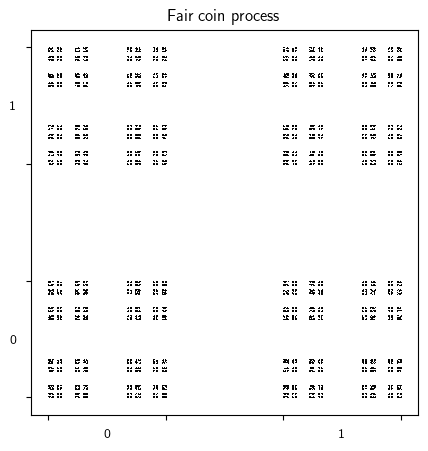

In [28]:
scatter_cantor(Xs[:10000],LP=7,LF=7,figsize=(5,5))
plt.title(r'Fair coin process',fontfamily='serif')
plt.savefig('faircoin_CANTOR.pdf')
plt.show()

### Clustered Cantor diagram

In [ ]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=7,LF=7),)

In [ ]:
fig, Z = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.17,matrix_rect=[0.34,0.1,0.6,0.8])
plt.savefig('faircoin_HCLUST.pdf')
plt.show()

### MDS Scatter plot (interactive)

In [ ]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
colors[np.where(colors=='k')] = '#000000'

Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
unq_pasts_txt = [''.join(s) for s in unq_pasts]
fig = go.Figure(
    data = [go.Scatter(
        x=Y[:,0],y=Y[:,0],mode='markers',hoverinfo='text',text=unq_pasts_txt,
        marker_color=colors,marker_opacity=0.5
    )],
)
fig.update_layout(title='Fair coin process (MDS coordinates)')

## Even process

### Generating data from process rules

In [29]:
def gen_even(
    n_iter:int=100,     # Total number of 0(11)* blocks to generate.
    p:float=0.5         # Geometric distribution parameter.
)->str:
    """
    Generates samples from the even process. These are generated as a sequence
    of blocks of the form 0(11)^n. n is drawn from the geometric distribution
    starting from n=0, with parameter p. The length of the datastream is roughly 
    ((2-p)/p)*n_iter, or 3*n_iter for the default p=0.5.
    """
    lengths = geom.rvs(p=p,size=n_iter)-1
    return reduce(concat,map(lambda n:'0'+'11'*n,lengths,),'')

In [30]:
Xs = np.array([x for x in gen_even(100000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  300442


### 2D Cantor plot

Computing Cantor pairs: 100%|████████████| 9987/9987 [00:00<00:00, 23699.64it/s]


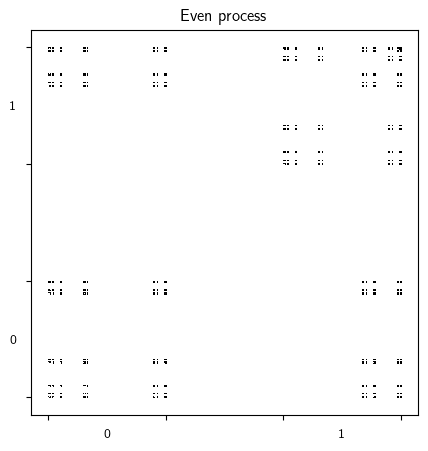

In [31]:
scatter_cantor(Xs[:10000],LP=7,LF=7,figsize=(5,5))
plt.title(r'Even process',fontfamily='serif')
plt.savefig('even_CANTOR.pdf')
plt.show()

### Clustered Cantor diagram

In [ ]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=7,LF=7),)

In [ ]:
fig, Z = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.17,matrix_rect=[0.34,0.1,0.6,0.8])
plt.savefig('even_HCLUST.pdf')
plt.show()

### MDS Scatter plot (paper figure & interactive)

Sometimes the MDS axes get swapped or flipped depending on small fluctuations in the
generated data; therefore, the labels may not be correctly located. You can
either regenerate the figure or consult the interactive scatter plot below to
determine the meaning of each cluster.

In [ ]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
colors[np.where(colors=='k')] = '#000000'

Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
fig = plt.figure(figsize=(5,5))
plt.scatter(Y[:,0],Y[:,1],edgecolor='k',c=colors,alpha=0.5,)
plt.axis('equal')

plt.text(0.12, 0.05,r'...$01^{2n}$')
plt.text(-0.09, -0.04,r'...$01^{2n+1}$')
plt.title(r'Even process',fontfamily='serif')

#plt.savefig('even_MDS.pdf')
plt.show()

In [ ]:
unq_pasts_txt = [''.join(s) for s in unq_pasts]
fig = go.Figure(
    data = [go.Scatter(
        x=Y[:,0],y=Y[:,0],mode='markers',hoverinfo='text',text=unq_pasts_txt,
        marker_color=colors,marker_opacity=0.5
    )],
)
fig.update_layout(title='Even process (MDS coordinates)')

## $a^nb^n$ process

### Generating data from process rules

In [32]:
def gen_anbn(
    n_iter:int=100,     # Number of a^n b^n blocks to generate.
    mu:float=1.0        # Poisson distribution scale parameter.
)->str:
    """
    Generates samples from the a^n b^n process. These are generated as a sequence
    of blocks of the form a^n b^n. n is drawn from the Poisson distribution with
    parameter mu, starting at 1. The length of the datastream is roughly
    2*(mu+1)*n_iter.
    """
    lengths = poisson.rvs(mu=mu,loc=1,size=n_iter)
    return reduce(concat,map(lambda n:'a'*n+'b'*n,lengths),'')

In [33]:
Xs = np.array([x for x in gen_anbn(500000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  2001320


### 2D Cantor plot

Computing Cantor pairs: 100%|████████████| 9987/9987 [00:00<00:00, 24637.91it/s]


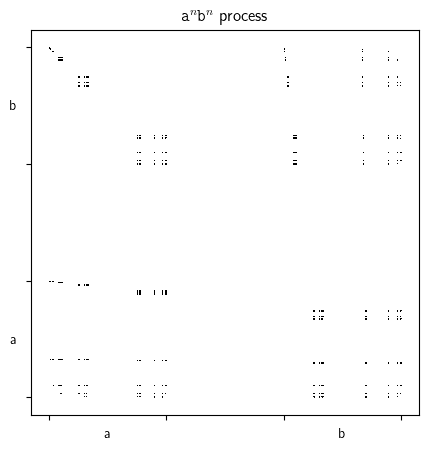

In [34]:
scatter_cantor(Xs[:10000],LP=7,LF=7,figsize=(5,5))
plt.title(r'$\mathtt{a}^n \mathtt{b}^n$ process',fontfamily='serif')
plt.savefig('anbn_CANTOR.pdf')
plt.show()

### Clustered Cantor diagram

In [ ]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=8,LF=8),)

In [ ]:
fig,Z = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.05,matrix_rect=[0.34,0.1,0.6,0.8])
plt.savefig('anbn_HCLUST.pdf')
plt.show()

### MDS Scatter plot (paper figure & interactive)

Due to fluctuations in the generated data, the exact location of clusters in the
scatter plot will shift, and so the labels may be slightly off. For that reason,
we provide an interactive figure to determine the meaning of each cluster.

In [ ]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
colors[np.where(colors=='k')] = '#000000'

Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
fig = plt.figure(figsize=(5,5))
plt.scatter(Y[:,0],Y[:,1],edgecolor='k',c=colors,alpha=0.5,)
plt.axis('equal')

plt.text(-0.27, -0.35,r'...$\mathtt{ba}^{n}\mathtt{b}^{n}$')
plt.text(-0.18, -0.15,r'...$\mathtt{ba}$')
plt.text(-0.12, 0.09,r'...$\mathtt{ba}^2$')
plt.text(-0.06, 0.2,r'...$\mathtt{ba}^3$')
plt.text(-0.01, 0.24,r'...$\mathtt{ba}^4$')
plt.text(0.03, 0.29,r'...$\mathtt{ba}^{5,6}$')
plt.text(0.15, -0.05,r'...$\mathtt{ba}^n\mathtt{b}^{n-1}$')
plt.text(0.19, 0.15,r'...$\mathtt{ba}^n\mathtt{b}^{n-2}$')
plt.text(0.19, 0.235,r'...$\mathtt{ba}^n\mathtt{b}^{n-3}$')
plt.title(r'$\mathtt{a}^n \mathtt{b}^n$ process',fontfamily='serif')
plt.savefig('anbn_MDS.pdf')
plt.show()


In [ ]:
unq_pasts_txt = [''.join(s) for s in unq_pasts]
fig = go.Figure(
    data = [go.Scatter(
        x=Y[:,0],y=Y[:,1],mode='markers',hoverinfo='text',text=unq_pasts_txt,
        marker_color=colors,marker_opacity=0.5
    )],
)
fig.update_layout(title=r'anbn process (MDS coordinates)')

## $a^n b^n c^n$ process

### Generate data from process rules

In [48]:
def gen_anbncn_poisson(
    n_iter:int=100,     # Number of a^n b^n c^n blocks to generate.
    mu:float=1.0        # Poisson distribution scale parameter.
)->str:
    """
    Generates samples from the a^n b^n c^n process. These are generated as a sequence
    of blocks of the form a^n b^n c^n. n is drawn from the Poisson distribution with
    parameter mu, starting at 1. The length of the datastream is roughly
    3*(mu+1)*n_iter.
    """
    lengths = poisson.rvs(mu=mu,loc=1,size=n_iter)
    return reduce(concat,map(lambda n:'a'*n+'b'*n+'c'*n,lengths),'')

In [49]:
Xs = np.array([x for x in gen_anbncn_poisson(400000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  2401407


### 2D Cantor plot

Computing Cantor pairs: 100%|████████████| 9987/9987 [00:00<00:00, 23626.58it/s]


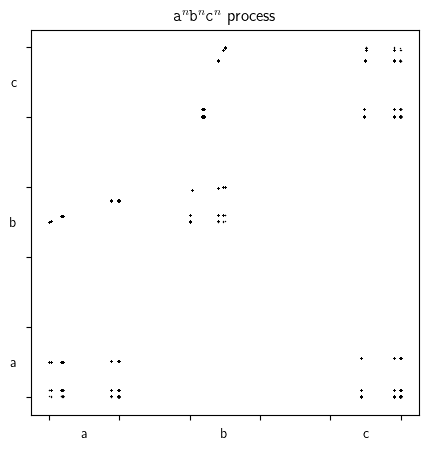

In [51]:
scatter_cantor(Xs[:10000],figsize=(5,5),LP=7,LF=7)
plt.title(r'$\mathtt{a}^n \mathtt{b}^n \mathtt{c}^n$ process',fontfamily='serif')
plt.savefig('anbncn_CANTOR.pdf')
plt.show()

### Clustered Cantor diagram

In [ ]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=8,LF=8),)

In [ ]:
fig,Z = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.05,matrix_rect=[0.34,0.1,0.6,0.8],)
plt.savefig('anbncn_HCLUST.pdf')
plt.show()

### MDS Scatter plot (interactive)

In [ ]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
colors[np.where(colors=='k')] = '#000000'

Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
unq_pasts_txt = [''.join(s) for s in unq_pasts]
fig = go.Figure(
    data = [go.Scatter(
        x=Y[:,0],y=Y[:,1],mode='markers',hoverinfo='text',text=unq_pasts_txt,
        marker_color=colors,marker_opacity=0.5
    )],
)
fig.update_layout(title=r'anbncn process (MDS coordinates)')

## $x+f(x)$ process

### Generating data from process rules

In [45]:
def gen_math_expr(
    n_iter:int=10   # Number of math expressions to generate.
)->str:
    """
    Generates samples from the x+f(x) process. These are generated using a
    probabilistic grammar. n_iter describes the total number of expressions (ending in
    a semicolon) that are to be generated. The grammar rules are applied by the
    function math_grammar.
    """
    s = 'S;'*n_iter
    return reduce(concat,map(math_grammar,s),'')

def math_grammar(
    b:str           # String to transform with production rules.
)->str:
    """
    Probabilistic production rules for the x+f(x) grammar. The user can toggle
    the probabilities directly in the function (as these are directly next to
    the affected terms, we felt this would be the most intuitive form of
    interaction. The currently given values are those used in the paper.)
    """
    if b == 'S':
        s = np.random.choice(['S+T','T'],p=[0.3,0.7])
        return reduce(concat,map(math_grammar,s),'')
    elif b == 'T':
        s = np.random.choice(['f(S)','x'],p=[0.5,0.5])
        return reduce(concat,map(math_grammar,s),'')
    else:
        return b

In [46]:
Xs = np.array([x for x in gen_math_expr(80000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  1000520


### 2D Cantor plot

Computing Cantor pairs: 100%|████████████| 9987/9987 [00:00<00:00, 23108.55it/s]


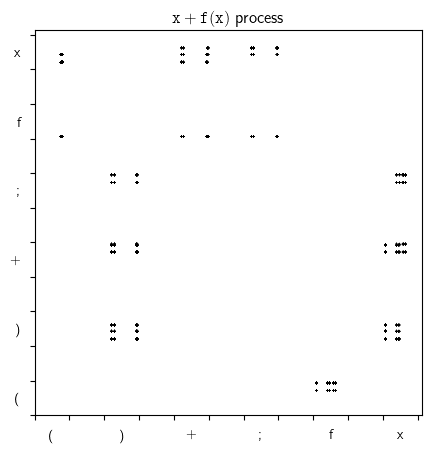

In [47]:
scatter_cantor(Xs[:10000],LP=7,LF=7,figsize=(5,5))
plt.title(r'$\mathtt{x+f(x)}$ process',fontfamily='serif')
plt.savefig('x+f(x)_CANTOR.pdf')
plt.show()

### Clustered Cantor diagram

In [ ]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=4,LF=4),)

In [ ]:
fig,Z = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.7*(1/8)**2)
plt.savefig('x+f(x)_HCLUST.pdf')
plt.show()

### MDS Scatter plot (interactive)

In [ ]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
colors[np.where(colors=='k')] = '#000000'

Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
unq_pasts_txt = [''.join(s) for s in unq_pasts]
fig = go.Figure(
    data = [go.Scatter(
        x=Y[:,0],y=Y[:,1],mode='markers',hoverinfo='text',text=unq_pasts_txt,
        marker_color=colors,marker_opacity=0.5
    )],
)
fig.update_layout(title=r'x+f(x) process (MDS coordinates)')

## Feigenbaum process

### Generating data from process rules

In [ ]:
def feig_grammar(
    b:str           # String to transform with substitution rules.
)->str:
    """
    We hope that the action of this function is self-explanatory.
    """
    if b == '0':
        return '11'
    elif b == '1':
        return '01'

def gen_feig_expr(
    n_double:int=10     # Number of times to apply substitution rules.
)->str:
    """
    Generates samples from the Feigenbaum process using the deterministic
    substitution method. This starts with a 0 and forcefully implements the
    transformation 0 -> 11 and 1 -> 01 for a specified number of iterations
    (n_double). As the name suggests, the total length of the string will scale
    as 2^n_double.
    """
    return reduce(lambda s,f:reduce(concat,map(f,s),''),[feig_grammar]*n_double,'0')

In [ ]:
Xs = np.array([x for x in gen_feig_expr(19)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

### 2D Cantor plot

In [ ]:
scatter_cantor(Xs[:10000],LP=7,LF=7,figsize=(7,7))
plt.savefig('feig_CANTOR.pdf')
plt.show()

### Clustered Cantor plots

In [ ]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=50,LF=50),)

In [ ]:
fig,Z = cluster_cantor(unq_pasts,cantors,wass,matrix_rect=[0.55,0.1,0.6,0.8],color_threshold=0.07)
plt.savefig('feig_HCLUST.pdf')
plt.show()

### MDS Scatter plot with dynamical comparison (paper figure + interactive)

This one will be a little different from the previous process examples: in
addition to the MDS scatter plot of predictive states, we will also plot an
equivalently color-coded diagram of the corresponding system states in the
logistic map system.

In [ ]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
colors[np.where(colors=='k')] = '#000000'

Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
unq_pasts_txt = [''.join(s) for s in unq_pasts]
fig = go.Figure(
    data = [go.Scatter(
        x=Y[:,0],y=Y[:,1],mode='markers',hoverinfo='text',text=unq_pasts_txt,
        marker_color=colors,marker_opacity=0.5
    )],
)
fig.update_layout(title=r'Feigenbaum process (MDS coordinates)')

Now, for the logistic map parameter $r = 3.56995$, we iterate the logistic map
process
$$
y_{t+1} = ry_t(1-y_t)
$$
over 10000 samples randomly initialized from $[0,1]$ uniformly. We iterate
`blind_iter` number of times to get "onto the attractor," and then iterate again
`vis_iter` times, only this time we record a $0$ if $y_t<1/2$ and a $1$ if
$y_t>1/2$. This results in a `vis_iter`-length string of symbols for each of the
10000 samples. The unique set of these strings corresponds to the unique pasts
of length `vis_iter` from the Feigenbaum process (this is, after all, how the
Feigenbuam process is traditionally generated). We choose `vis_iter` to equal 50
here because that was the past length we chose to compute the Wasserestein
distances at. We plot our 10000 samples below, with each sampled by whichever
cluster its symbol string belongs to according to the dendrogram plotted above.

In [ ]:
r = 3.56995
y = np.random.rand(10000)
blind_iter = 5000
vis_iter = 50
samples = ['']*len(y)
for _ in range(blind_iter):
    y = r*y*(1-y)
for _ in range(vis_iter):
    y = r*y*(1-y)
    samples = [s1+s2 for s1,s2 in zip(samples,((y>0.5).astype(int)).astype(str))]
samples = np.array(samples)

sample_colors = colors[[np.where(np.array(unq_pasts_txt)==s)[0][0] for s in samples]]

fig = go.Figure(
    data = [go.Scatter(
        x=y,y=r*y*(1-y),mode='markers',hoverinfo='text',text=samples,
        marker_color=sample_colors,marker_opacity=0.1
    )],
)
fig.update_layout(
    title=r'Feigenbaum process (MDS coordinates)',
    yaxis=dict(title=r'ry(1-y)'),
    xaxis=dict(title=r'y')
)


For the paper, we displayed both plots side-by-side, with additional visual aid
in the form of color-coded arrows showing where each cluster gets mapped in the
logistic domain. These arrows must be colored manually to match the colors
assigned to the clusters. It is possible, but not likely, that this assignment may change due to
fluctuations in the data prompting the dendrogram to order the clusters slightly differently.

In [ ]:

plt.rcParams['text.usetex'] = False

fig,axs = plt.subplots(1,2,figsize=(17,4),gridspec_kw=dict(width_ratios=[3,1]))

axs[0].scatter(Y[:,0],Y[:,1],edgecolor='k',alpha=0.5,c=colors,cmap='Set1')
axs[0].set_title('Clustered reconstructed states (MDS coordinates)',fontsize=14,fontfamily='serif')

xrange = np.linspace(np.min(y),np.max(y),2)
axs[1].scatter(y,r*y*(1-y),edgecolor='k',linewidth=0.5,alpha=0.01,c=sample_colors,cmap='Set1')
axs[1].plot(xrange,xrange,c='k',linewidth=1,linestyle=':')
axs[1].set_ylabel(r'$y_{t+1}\ =\ ry_t(1-y_t)$',fontsize=12,fontfamily='serif')
axs[1].set_xlabel(r'$y_t$',fontsize=12,fontfamily='serif')
axs[1].set_title(r'Actual logistic map states & dynamics',fontsize=14,fontfamily='serif')

lax = axs[1]
alpha=0.3
lax.annotate('', xy=(0.88, 0.89),  xycoords='data',
            xytext=(0.58, 0.89), textcoords='data',
            arrowprops=dict(facecolor=cmap[2],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.89, 0.4),  xycoords='data',
            xytext=(0.89, 0.88), textcoords='data',
            arrowprops=dict(facecolor=cmap[2],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.87, 0.88),  xycoords='data',
            xytext=(0.58, 0.88), textcoords='data',
            arrowprops=dict(facecolor=cmap[3],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.88, 0.4),  xycoords='data',
            xytext=(0.88, 0.87), textcoords='data',
            arrowprops=dict(facecolor=cmap[3],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.835, 0.845),  xycoords='data',
            xytext=(0.41, 0.845), textcoords='data',
            arrowprops=dict(facecolor=cmap[3],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.845, 0.5),  xycoords='data',
            xytext=(0.845, 0.835), textcoords='data',
            arrowprops=dict(facecolor=cmap[3],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )

lax.annotate('', xy=(0.81, 0.82),  xycoords='data',
            xytext=(0.39, 0.82), textcoords='data',
            arrowprops=dict(facecolor=cmap[4],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.82, 0.58),  xycoords='data',
            xytext=(0.82, 0.81), textcoords='data',
            arrowprops=dict(facecolor=cmap[4],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.54, 0.53),  xycoords='data',
            xytext=(0.8, 0.53), textcoords='data',
            arrowprops=dict(facecolor=cmap[5],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.53, 0.86),  xycoords='data',
            xytext=(0.53, 0.54), textcoords='data',
            arrowprops=dict(facecolor=cmap[5],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )

lax.annotate('', xy=(0.49, 0.48),  xycoords='data',
            xytext=(0.81, 0.48), textcoords='data',
            arrowprops=dict(facecolor=cmap[1],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.48, 0.87),  xycoords='data',
            xytext=(0.48, 0.49), textcoords='data',
            arrowprops=dict(facecolor=cmap[1],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.39, 0.38),  xycoords='data',
            xytext=(0.86, 0.38), textcoords='data',
            arrowprops=dict(facecolor=cmap[1],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.38, 0.8),  xycoords='data',
            xytext=(0.38, 0.39), textcoords='data',
            arrowprops=dict(facecolor=cmap[1],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.37, 0.36),  xycoords='data',
            xytext=(0.87, 0.36), textcoords='data',
            arrowprops=dict(facecolor=cmap[0],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.36, 0.79),  xycoords='data',
            xytext=(0.36, 0.37), textcoords='data',
            arrowprops=dict(facecolor=cmap[0],alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
plt.savefig('feig_MDS.pdf',bbox_inches='tight')
plt.show()